<a href="https://colab.research.google.com/github/nomnomnonono/GAN/blob/main/CGAN/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jan 15 12:55:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## library

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

## setting

In [ ]:
batch_size = 64
sample_size = 100
epoch = 100
lr = 0.0002
beta = 0.5
alpha = 0.01
result_dir = '/content/drive/MyDrive/GAN/CGAN/result'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## data

In [ ]:
transform = transforms.ToTensor()
train = datasets.MNIST(root='.data', train=True, download=True, transform=transform)
train_loader = DataLoader(train, batch_size=64, shuffle=True, drop_last=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



## model

In [ ]:
class Generator(nn.Module):
  def __init__(self, batch_size, sample_size):
    super().__init__()
    # setting
    self.sample_size = sample_size
    self.batch_size = batch_size
    # layer
    self.fc = nn.Sequential(
        nn.Linear(self.sample_size, 784, bias=False),
        nn.BatchNorm1d(784),
        nn.ReLU(),
    )
    self.conv1 = nn.Sequential(
        nn.ConvTranspose2d(16, 8, 5, 2, 2, output_padding=1, bias=False),
        nn.BatchNorm2d(8),
        nn.ReLU()
    )
    self.conv2 = nn.Sequential(
        nn.ConvTranspose2d(8, 1, 5, 2, 2, output_padding=1, bias=False),
        nn.BatchNorm2d(1),
        nn.Tanh()
    )
    self.embedding = nn.Embedding(10, self.sample_size)

  def forward(self, y, device):
    z = torch.randn(self.batch_size, self.sample_size).to(device)
    y = self.embedding(y)
    x = torch.mul(z, y)
    x = self.fc(x)
    x = x.reshape(self.batch_size, 16, 7, 7)
    x = self.conv1(x)
    x = self.conv2(x)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, alpha):
    super().__init__()
    # layer
    self.conv1 = nn.Sequential(
        nn.Conv2d(2, 16, 5, 2, 2, bias=False),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(alpha)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 8, 5, 2, 2, bias=False),
        nn.BatchNorm2d(8),
        nn.LeakyReLU(alpha)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(8, 1, 7, 1, 0, bias=False),
        nn.Sigmoid()
    )
    self.embedding = nn.Embedding(10, 784)

  def forward(self, x, y):
    y = self.embedding(y)
    y = y.reshape(-1, 1, 28, 28)
    x = torch.concat([x, y], dim=1)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = torch.squeeze(x)
    return x

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## train

In [ ]:
net_G = Generator(batch_size=batch_size, sample_size=sample_size).to(device)
net_D = Discriminator(alpha=alpha).to(device)
net_G.apply(weights_init)
net_D.apply(weights_init)
opt_G = Adam(net_G.parameters(), lr=lr, betas=(beta, 0.999))
opt_D = Adam(net_D.parameters(), lr=lr, betas=(beta, 0.999))
criterion = nn.BCELoss()
y_real = torch.ones(batch_size).to(device)
y_fake = torch.zeros(batch_size).to(device)
G_losses = []
D_losses = []
x = np.random.randint(0, 10, 64)
x[0:10] = np.arange(0, 10)
test_label = torch.tensor(x, dtype=torch.long).to(device)

In [ ]:
for ep in range(epoch):
  d_loss = []
  g_loss = []

  for i, (x, y) in enumerate(train_loader):
    x = x.to(device)
    y = y.to(torch.long).to(device)
    ## train D
    net_D.zero_grad()
    # real
    out_real = net_D(x, y)
    loss_D_real = criterion(out_real, y_real)
    loss_D_real.backward()
    D_x = out_real.mean().item()
    # false
    fake_label = torch.tensor(np.random.randint(0, 10, 64), dtype=torch.long).to(device)
    fake = net_G(fake_label, device)
    out_fake = net_D(fake.detach(), fake_label)
    loss_D_fake = criterion(out_fake, y_fake)
    loss_D_fake.backward()
    D_G_z1 = out_fake.mean().item()
    loss_D = (loss_D_real + loss_D_fake) / 2
    opt_D.step()

    ## train G
    net_G.zero_grad()
    out_fake = net_D(fake, fake_label)
    loss_G = criterion(out_fake, y_real)
    loss_G.backward()
    D_G_z2 = out_fake.mean().item()
    opt_G.step()

    if (i % 100 == 0):
      print("[%d/%d][%d/%d]\tLossD: %.4f\tLossG: %.4f" % (ep, epoch, i, len(train_loader), loss_D.item(), loss_G.item()))
    
    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())
  
  if (ep+1) % 10 == 0:
    net_G.eval()
    with torch.no_grad():
      out = net_G(test_label, device)
      save_image(out[0:10, :, :, :], os.path.join(result_dir, "epoch%d.png" % (ep+1)), nrow=10)
      torch.save(net_D.state_dict(), os.path.join(result_dir, "D_%d.pth" % (ep+1)))
      torch.save(net_G.state_dict(), os.path.join(result_dir, "G_%d.pth" % (ep+1)))

[0/100][0/937]	LossD: 0.7065	LossG: 0.5768
[0/100][100/937]	LossD: 0.4262	LossG: 1.0850
[0/100][200/937]	LossD: 0.2108	LossG: 1.8407
[0/100][300/937]	LossD: 0.0735	LossG: 3.1198
[0/100][400/937]	LossD: 0.0392	LossG: 3.6559
[0/100][500/937]	LossD: 0.0498	LossG: 3.3894
[0/100][600/937]	LossD: 0.0669	LossG: 3.3785
[0/100][700/937]	LossD: 0.0997	LossG: 2.8132
[0/100][800/937]	LossD: 0.2863	LossG: 1.8401
[0/100][900/937]	LossD: 0.1742	LossG: 2.1952
[1/100][0/937]	LossD: 0.2113	LossG: 1.5870
[1/100][100/937]	LossD: 0.2711	LossG: 3.4604
[1/100][200/937]	LossD: 0.1870	LossG: 2.5444
[1/100][300/937]	LossD: 0.2327	LossG: 1.7927
[1/100][400/937]	LossD: 0.1585	LossG: 1.9617
[1/100][500/937]	LossD: 0.1290	LossG: 2.1187
[1/100][600/937]	LossD: 0.1733	LossG: 2.8753
[1/100][700/937]	LossD: 0.1141	LossG: 2.5570
[1/100][800/937]	LossD: 0.1566	LossG: 1.9400
[1/100][900/937]	LossD: 0.1076	LossG: 3.2360
[2/100][0/937]	LossD: 0.0964	LossG: 3.1301
[2/100][100/937]	LossD: 0.1017	LossG: 2.8120
[2/100][200/937]

## visualization

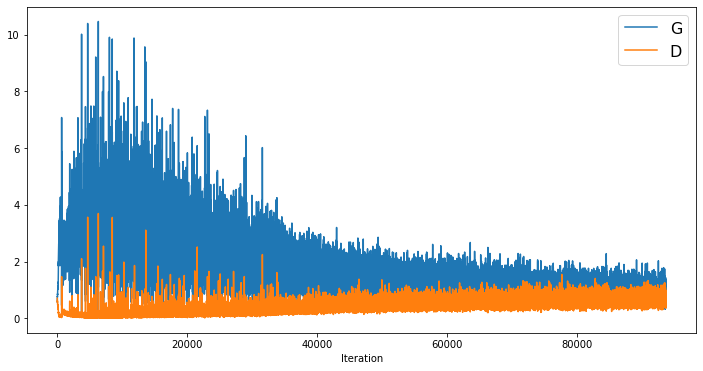

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(G_losses, label='G')
plt.plot(D_losses, label='D')
plt.xlabel('Iteration')
plt.legend(fontsize=16)
plt.savefig(os.path.join(result_dir, 'loss.png'))